In [1]:
# import and set options
import warnings
warnings.filterwarnings("ignore")
import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')
%matplotlib inline
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import scipy.stats as stats
import matplotlib as mpl
import sklearn
import utils
mpl.rcParams['pdf.fonttype'] = 42

## Analysis of Prostate Adenocarcinoma

Here, we perform a detailed analysis of 1,013 prostate adenocarcinoma samples from [Armenia et al](https://www.ncbi.nlm.nih.gov/pubmed/?term=29610475). This allows us to assess whether the expected trajectory of discovery for prostate adenocarcinoma (see [Sub-sampling analysis](Sub-sampling analysis.ipynb)) from The Cancer Genome Atlas (n=477) matches what is observed from more than 1,000 samples. Using only the TCGA, sub-sampling analysis suggested linear increases in the number of unique driver missense mutations and only gradual increases in the prevalence with perhaps diminishing returns. The TCGA data yielded an estimate of 0.31 driver missense mutations per sample. Raw results and mutations from Armenia et al are in the `CHASMplus/data/armenia_et_al_2018_prostate` folder.

Additionally, since Armenia et al only performed gene-level analysis, this will also be informative in providing greater resolution to our understanding of cancer drivers at the level of individual mutations in prostate adenocarcinoma.

### Data processing 

The first step is to read in the CHASMplus predictions and the mutations from Armenia et al.

In [2]:
# read in CHASMplus predictions
df = utils.read_result('Armenia_et_al_PRAD', 
                       base_dir='CHASMplus/data/armenia_et_al_2018_prostate/', 
                       change_col_name=False)
df['CODE'] = 'PRAD'
df['Protein_position'] = df['HGVSp_Short'].str[3:-1]
df = df.rename(columns={'CHASM2_genome_qval': 'gwCHASMplus q-value'})

In [3]:
# Read in mutations from Armenia et al and merge in CHASMplus results
mut_df = pd.read_table('CHASMplus/data/armenia_et_al_2018_prostate/Armenia_et_al_PRAD.maf').rename(columns={'Protein_Change': 'HGVSp_Short'})
mut_df = pd.merge(mut_df, df, 
                  on=['Hugo_Symbol', 'HGVSp_Short'],
                  how='left')

### Comparison of unique driver missense mutations

In the TCGA analysis we noted that Prostate Adenocarcinoma, like other cancer types, linearly increased in terms of the number unique driver mutations. The original TCGA analysis found 94 unique driver missense mutations at a false discovery rate of 1%. A strictly linear increase would expect 200 unique driver missense mutations for 1,013 samples (=94 mutations / 477 samples * 1,013 samples).

In [4]:
# count the number of unique significant mutations
is_signif = df['gwCHASMplus q-value']<=.01
num_unique_drivers = len(df[is_signif])
print('Number of unique driver missense mutations: {0}'.format(num_unique_drivers))

Number of unique driver missense mutations: 203


In [5]:
df[is_signif][['Hugo_Symbol', 'HGVSp_Short']]['Hugo_Symbol'].value_counts()

TP53      65
SPOP      27
CTNNB1    19
PTEN      11
KDM6A     11
PIK3CA     9
CDK12      7
KRAS       5
AR         5
BRAF       5
MED12      4
PIK3CB     4
FOXA1      3
IDH1       3
ATM        3
CUL3       3
APC        3
HRAS       2
USP48      2
RAG1       2
ITSN1      2
CNOT3      2
AKT1       2
CDC23      1
ERF        1
RNF43      1
RB1        1
Name: Hugo_Symbol, dtype: int64

Indeed, we find 203 unique driver missense mutations from the data in Armenia et al, strikingly close to expectations.

### Comparison of driver prevalence

First, we examine the prevalence of driver missense mutations with this expanded data set compared to that from the TCGA. To compare the two, we use the average number of driver missense mutations per sample. Like in the TCGA analysis, a 1% false discovery rate threshold is used.

In [6]:
# Calculate the number of significant mutations
is_signif = mut_df['gwCHASMplus q-value']<=.01
num_muts = len(mut_df[is_signif])

# print out the comparison
print('The driver prevalence is {0:.2f} mutations per sample compared with 0.31 mutations per sample from the TCGA data'.format(num_muts / 1013))

The driver prevalence is 0.40 mutations per sample compared with 0.31 mutations per sample from the TCGA data


Like expected, driver prevalence increased gradually but with a rate showing diminishing returns. A strictly linear increase would have yielded 0.66 mutations per sample. Next, we looked at mutations that were marginally significant at a false discovery rate of 5%.

In [7]:
# Calculate the number of significant mutations at 5% FDR
is_signif = mut_df['gwCHASMplus q-value']<=.05
num_muts = len(mut_df[is_signif])

print('At 5% FDR, the driver prevalence is {0:.2f} mutations per sample'.format(num_muts / 1013))

At 5% FDR, the driver prevalence is 0.48 mutations per sample


Despite the diminishing returns for discovery, there are a reasonable prevalence of driver missense mutations that are marginally significant, suggesting that discovery is not saturated.

In [8]:
# calculate the fraction of samples containing an identified driver
mutated_samps = mut_df[is_signif].groupby(['CODE'])['Tumor_Sample_Barcode'].nunique()
num_muts = len(mut_df[is_signif])
total_samps = mut_df['Tumor_Sample_Barcode'].nunique()

### Comparison of driver genes with Armenia et al



In [9]:
armenia_gene_list = [
    'TP53', 'SPOP', 'FOXA1', 'APC', 'PTEN', 'CDK12', 'KMT2D', 'PIK3CA', 'ZFHX3', 'KMT2C',
    'ATM', 'CDKN1B', 'KDM6A', 'CTNNB1', 'RNF43', 'USP28', 'RB1', 'BRCA2', 'PIK3R1', 'NDST2',
    'ZNF292', 'TAF1L', 'NCOR1', 'ERF', 'CHD1', 'AKT1', 'MED12', 'ITSN1', 'USP7', 'IDH1',
    'MGA', 'CHD3', 'ETV3', 'CDC27', 'IL6ST', 'CUL3', 'CHD7', 'DHX30', 'COL15A1', 'PAX6',
    'CNOT3', 'TMPRSS2', 'KRAS', 'SETDB1', 'RNF31', 'AR', 'MRE11A', 'ARID4A', 'JADE2', 'PTPRC',
    'ZMYM3', 'IGF2R', 'EHHADH', 'BRAF', 'COL5A3', 'RPRD2', 'SMARCAD1', 'BRPF1', 'SLC4A2', 'SPATA18',
    'UNC13D', 'PIK3R2', 'PPL', 'TBC1D2', 'CDH1', 'U2AF1', 'HRAS', 'ADAMTS8', 'SMARCA1', 'MET',
    'SPEN', 'ITSN2', 'COL5A1', 'PYHIN1', 'JAK1', 'MATN4', 'PIK3CB', 'RAG1', 'TAP1', 'CHD6',
    'TRPM4', 'WASF3', 'SF3B1', 'PMS1', 'MYBBP1A', 'PDS5A', 'SAMD9', 'PALB2', 'STAB2', 'MBD1',
    'NOX3', 'XPO1', 'KEAP1', 'KMT2A', 'ARID1A', 'SETD2', 'ARID2'
]

In [10]:
# Get the unique genes at a FDR of 1% and 5%
chasmplus_list_01 = df[df['gwCHASMplus q-value']<=0.01]['Hugo_Symbol'].unique()
chasmplus_list_05 = df[df['gwCHASMplus q-value']<=0.05]['Hugo_Symbol'].unique()

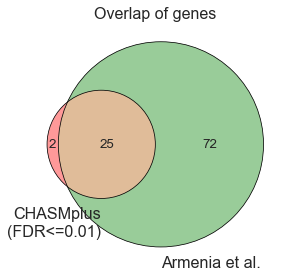

In [11]:
from matplotlib_venn import venn2, venn2_circles

# figure out the overlap
len_intersect = len(set(chasmplus_list_01) & set(armenia_gene_list))
len_chasmplus = len(chasmplus_list_01)
len_armenia = len(armenia_gene_list)
overlap = (len_chasmplus - len_intersect, len_armenia - len_intersect, len_intersect)

# plot venn diagram
with sns.plotting_context('paper', font_scale=1.4):
    venn2(subsets=overlap, set_labels=('CHASMplus\n(FDR<=0.01)', 'Armenia et al.'))
    venn2_circles(subsets=overlap, linestyle='solid', linewidth=.75)
    plt.title('Overlap of genes', size=16)
    plt.tight_layout()
    plt.savefig('CHASMplus/figures/figure_S7b.pdf')

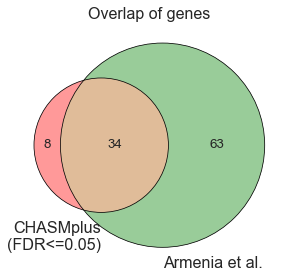

In [12]:
# figure out the overlap
len_intersect = len(set(chasmplus_list_05) & set(armenia_gene_list))
len_chasmplus = len(chasmplus_list_05)
len_armenia = len(armenia_gene_list)
overlap = (len_chasmplus - len_intersect, len_armenia - len_intersect, len_intersect)

# plot venn diagram
with sns.plotting_context('paper', font_scale=1.4):
    venn2(subsets=overlap, set_labels=('CHASMplus\n(FDR<=0.05)', 'Armenia et al.'))
    venn2_circles(subsets=overlap, linestyle='solid', linewidth=.75)
    plt.title('Overlap of genes', size=16)
    plt.tight_layout()
    plt.savefig('CHASMplus/figures/figure_S7c.pdf')

We note that there are three reasons why there is a larger number of genes reported in Armenia et al: 1) they refelct genes driven by mutations other than missense mutations; 2) They selectively rescued previously known cancer genes seen in other types of cancers; and 3) They used a considerably laxer threshold at a False discovery rate of 25%.

In [13]:
twentyTwentyPlus = pd.read_table('CHASMplus/data/armenia_et_al_2018_prostate/2020plus_results.txt')
is_driver = twentyTwentyPlus['driver q-value']<=0.1
is_og = twentyTwentyPlus['oncogene q-value']<=0.1
is_tsg = twentyTwentyPlus['tsg q-value']<=0.1
twentyTwentyPlus_genes = twentyTwentyPlus[is_og | is_tsg | is_driver]['gene'].unique()

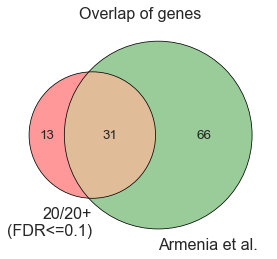

In [14]:
# figure out the overlap
len_intersect = len(set(twentyTwentyPlus_genes) & set(armenia_gene_list))
len_ttplus = len(twentyTwentyPlus_genes)
len_armenia = len(armenia_gene_list)
overlap = (len_ttplus - len_intersect, len_armenia - len_intersect, len_intersect)

# plot venn diagram
with sns.plotting_context('paper', font_scale=1.4):
    venn2(subsets=overlap, set_labels=('20/20+\n(FDR<=0.1)', 'Armenia et al.'))
    venn2_circles(subsets=overlap, linestyle='solid', linewidth=.75)
    plt.title('Overlap of genes', size=16)

### Format supplementary tables

In [17]:
frac_samples = mut_df[is_signif].groupby(['Hugo_Symbol', 'Protein_position']).size() / total_samps
frequency_df = frac_samples.reset_index(name='fraction of samples')
supp_table = pd.merge(df, frequency_df, on=['Hugo_Symbol', 'Protein_position'], how='left')
supp_table = supp_table[supp_table['gwCHASMplus q-value']<=0.05]
supp_table['Note'] = 'Marginally significant'
supp_table.loc[supp_table['gwCHASMplus q-value']<=0.01, 'Note'] = 'Significant'
cols = ['Hugo_Symbol', 'HGVSp_Short', 'fraction of samples', 'gwCHASMplus q-value', 'Note']
supp_table[cols].to_csv('CHASMplus/results/table_S6.txt', sep='\t', index=False)